In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from autoencoder import create_encoders, create_conv_encoders, fit_encoders, create_full_model, \
    fit_full_model, create_fc_layers, create_seq_model
from preprocess import load_clean_data, data_stats, plot_samples, plot_avg, plot_ewma, create_features, \
    create_features_labels
from plots import plot_validation_diagram

Using TensorFlow backend.


In [126]:
data = load_clean_data([0, 1])
validation = load_clean_data([3])

In [158]:
#plot_samples(data)

In [159]:
#plot_avg(data[0]['signals'], 400)

In [160]:
#plot_ewma(data[0]['signals'], 400)

### autoencoder data

In [127]:
beats = create_features(data, 784)
x_train_beats, x_test_beats = train_test_split(beats, test_size = 0.2, random_state = 0)

### full model data

In [128]:
lb = LabelBinarizer()
x_train, labels = create_features_labels(data, 784, non_beats_per_beat = 2)
y_train = lb.fit_transform(labels)

x_test, labels = create_features_labels(validation, 784, non_beats_per_beat = 2)
y_test = lb.transform(labels)

In [129]:
x_train.shape, x_test.shape

((12387, 784), (6246, 784))

In [130]:
print(lb.classes_)

['A' 'N' 'NB']


In [131]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [132]:
ann[ann['Type'] == 'A']

Time  Sample Type
1357  19:21.875  418275    A
1588  22:40.108  489639    A

In [2]:
def print_raport(models):
    d = [(ae, fc, models[ae]['full_models'][fc]['val_acc']) for ae in models.keys() for fc in models[ae]['full_models']]
    df = pd.DataFrame(d, columns=['AE', 'FC', 'val_acc'])
    display(df)

In [3]:
def print_seq_raport(models):
    d = [(m['config']['filters'], m['config']['units'], m['config']['dropout'], m['val_acc']) for m in models]
    df = pd.DataFrame(d, columns=['filters', 'units', 'dropout', 'val_acc'])
    display(df)

In [4]:
def evaluate_full_model(encoder, config, encoder_name, load_prev, epochs = 2):
    models = {}
    for layers_dim in config:
        model_name = str(layers_dim)
        print('Evaluating model with fc:', model_name)
        model = create_full_model(encoder, layers_dim)        
        h = fit_full_model(model, x_train, x_test, y_train, y_test, epochs=epochs, 
                       filename=encoder_name + model_name, load_prev=load_prev, verbose=0)
        models[model_name] = { 'model' : model, 'val_acc' : h.history['val_acc'][-1] }
        plot_validation_diagram(model, lb.classes_, ann, sig,  418275 - 2000, 418275 + 2500)        
        
    return models

In [5]:
def evaluate_nn_models(config, ae_epochs= 1, full_model_epochs = 1, load_prev_ae = True, load_prev_full = True):
    models = {}    
    for layers_dim in config['ae']:
        ae_name = str(layers_dim)
        print('Running autoencoder with config:', ae_name)
        encoders = create_encoders(*layers_dim)        
        h = fit_encoders(encoders, x_train, x_test, epochs=ae_epochs, filename=ae_name + '.h5', 
                         load_prev=load_prev_ae, verbose=0)
        
        full_models = evaluate_full_model(encoders[1], config['fc'], ae_name, load_prev_full, epochs=full_model_epochs)
        models[ae_name] = {'encoders': encoders, 'full_models': full_models}
    print_raport(models)            
    return models

In [6]:
def evaluate_conv_models(config, ae_epochs= 1, full_model_epochs = 1, load_prev_ae = True, load_prev_full = True):
    models = {}   
    ae_name = 'conv_16_8_8'
    print('Running convolution autoencoder with config:', ae_name)
    encoders = create_conv_encoders()    
    h = fit_encoders(encoders, x_train, x_test, epochs=ae_epochs, filename=ae_name + '.h5', load_prev=load_prev_ae, verbose=0)
    full_models = evaluate_full_model(encoders[1], config['fc'], ae_name, load_prev_full, epochs=full_model_epochs)
    models[ae_name] = {'encoders': encoders, 'full_models': full_models}
    print_raport(models)    
    return models

In [7]:
def evaluate_seq_models(config, epochs= 1, load_prev = True):
    models = [] 
    for c in config:
        model_name = str(c)
        print('Running sequential model with config:', model_name)
        model = create_seq_model(filters = c['filters'], units = c['units'], dropout=c['dropout'])
        h = fit_full_model(model, x_train, x_test, y_train, y_test, epochs=epochs, filename=model_name +'.h5', 
                       load_prev=load_prev, verbose=1)
        models.append({ 'model' : model, 'val_acc' : h.history['val_acc'][-1], 'config' : c })
        plot_validation_diagram(model, lb.classes_, ann, sig,  418275 - 2000, 418275 + 2500)   
    
    print_seq_raport(models)    
    return models

Running autoencoder with config: [784, [], 64]


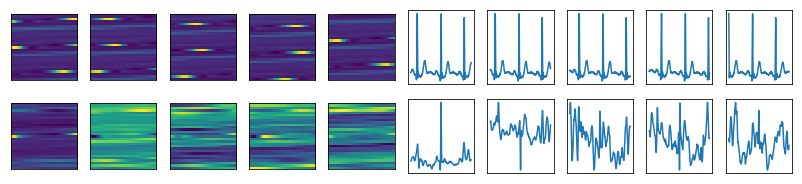

Evaluating model with fc: [3]


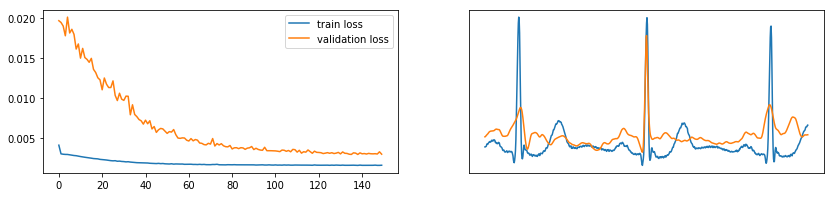

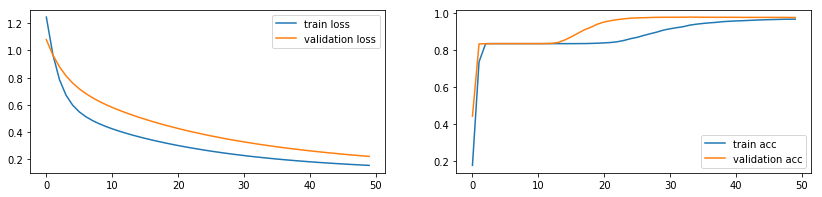

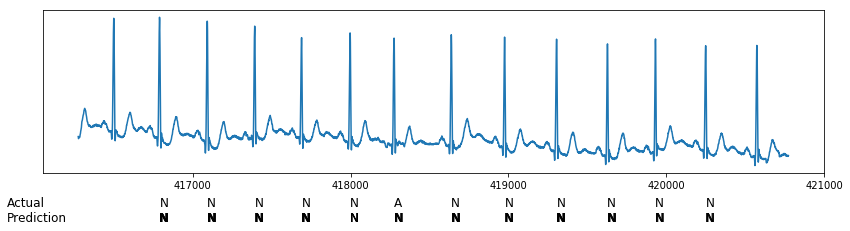

Evaluating model with fc: [32, 3]


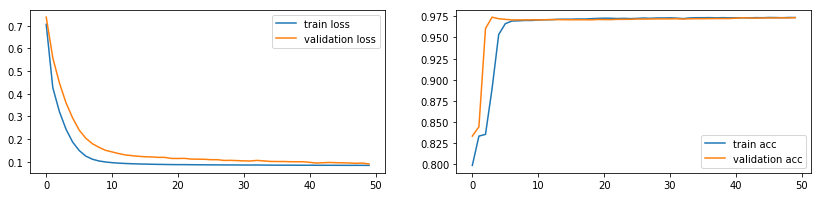

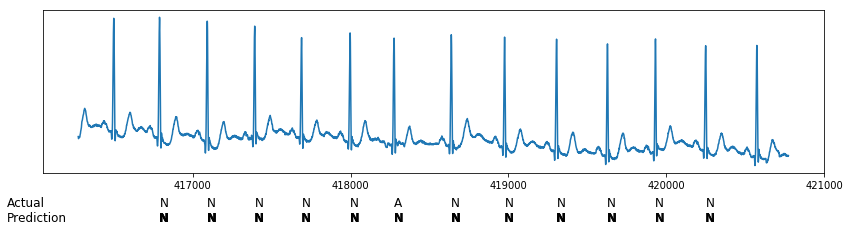

Evaluating model with fc: [64, 3]


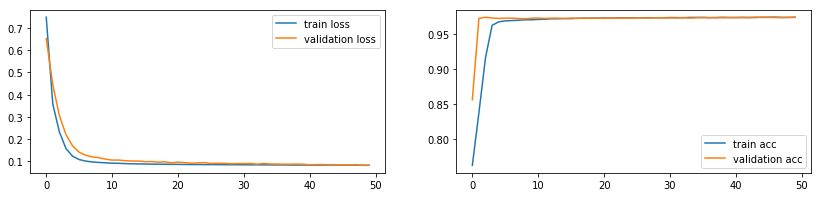

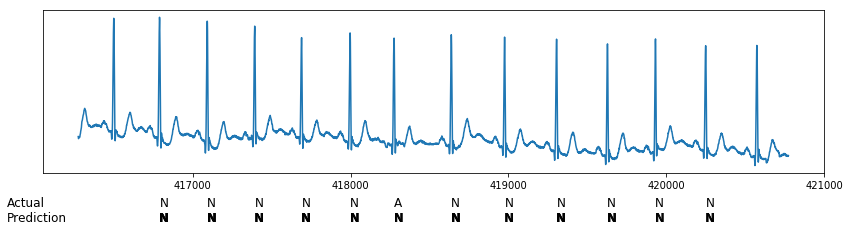

Running autoencoder with config: [784, [256, 128], 64]


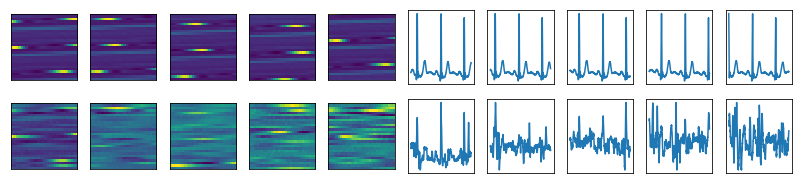

Evaluating model with fc: [3]


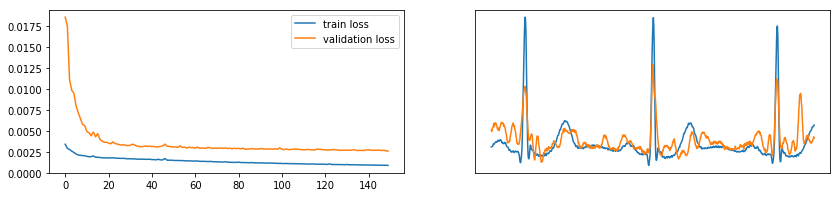

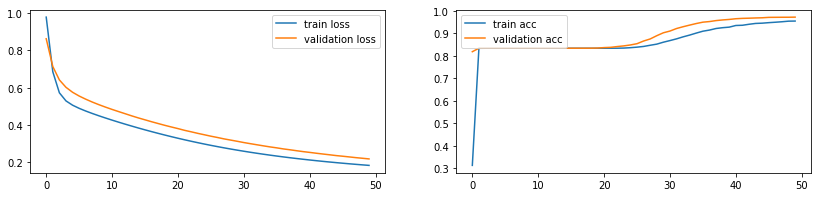

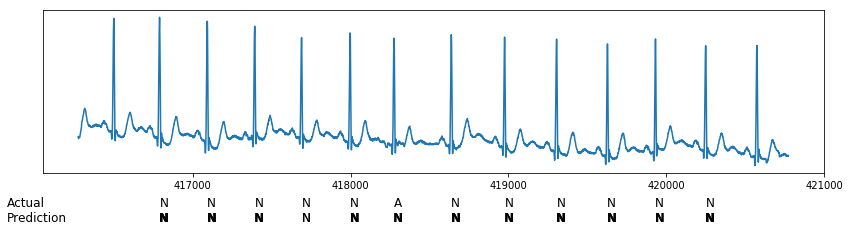

Evaluating model with fc: [32, 3]


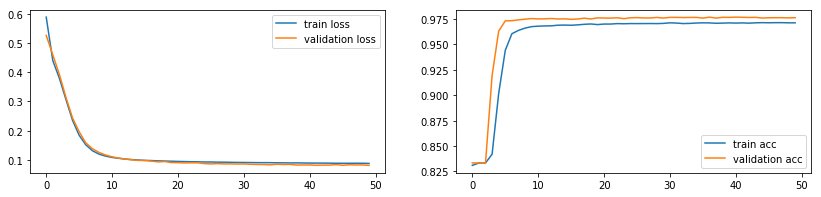

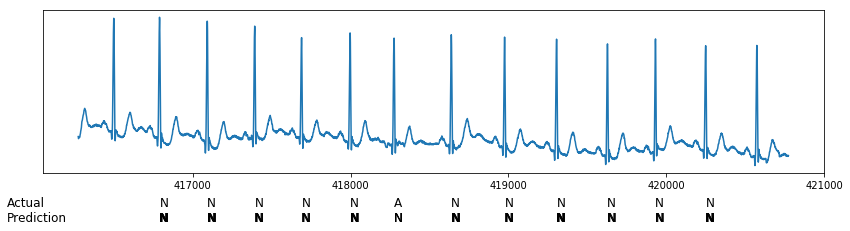

Evaluating model with fc: [64, 3]


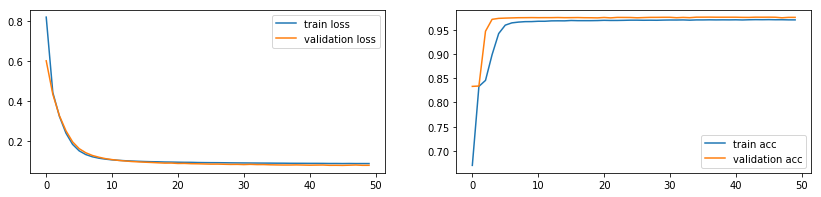

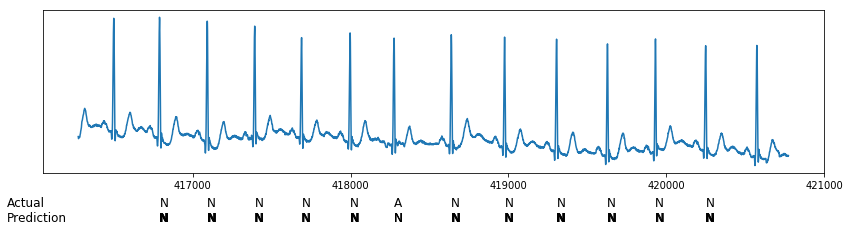

In [82]:
config = {
    'ae' : [ [784,[], 64], [784, [256, 128], 64]],
    'fc' : [ [3], [32,3], [64,3] ]
}
nn_models = evaluate_nn_models(config, 150, 50, load_prev_ae=False, load_prev_full=False)

In [84]:
print_raport(nn_models)

AE       FC   val_acc
0          [784, [], 64]      [3]  0.974704
1          [784, [], 64]  [32, 3]  0.973423
2          [784, [], 64]  [64, 3]  0.973903
3  [784, [256, 128], 64]      [3]  0.971822
4  [784, [256, 128], 64]  [32, 3]  0.976385
5  [784, [256, 128], 64]  [64, 3]  0.976305

Running convolution autoencoder with config: conv_16_8_8


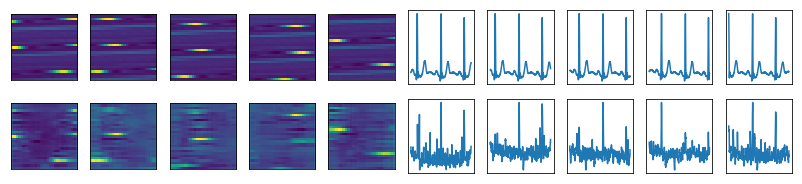

Evaluating model with fc: [3]


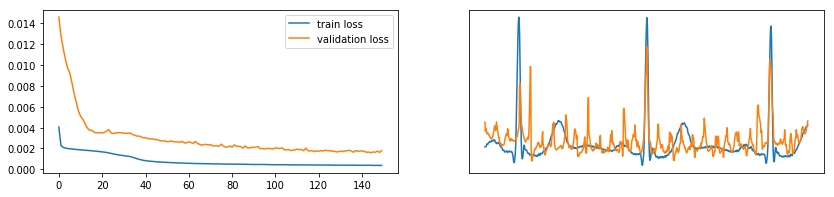

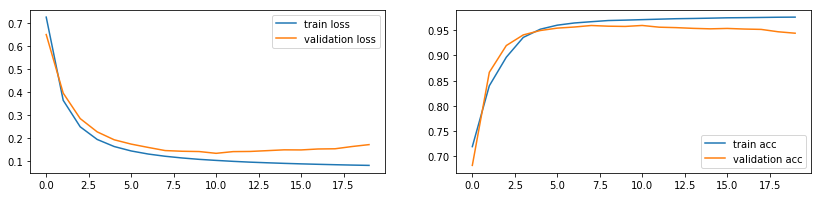

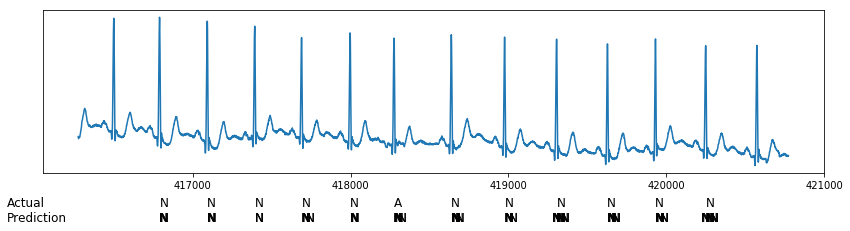

Evaluating model with fc: [64, 3]


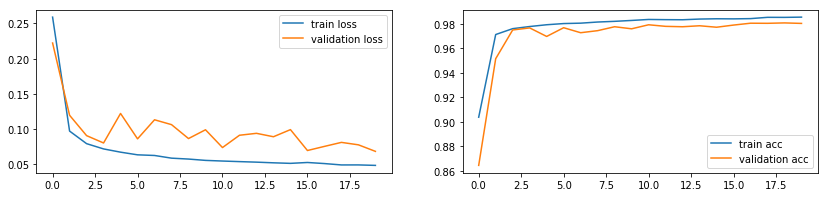

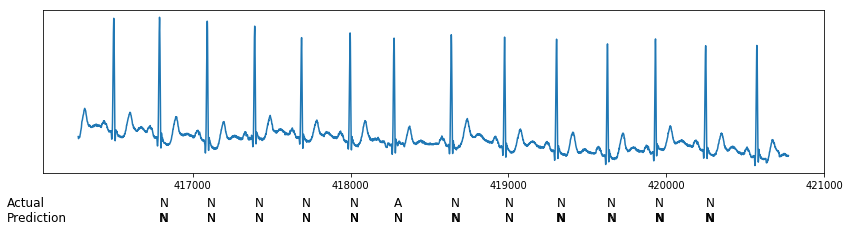

AE       FC   val_acc
0  conv_16_8_8      [3]  0.944364
1  conv_16_8_8  [64, 3]  0.980387

In [83]:
config = {
    'fc' : [ [3], [64,3] ]
}
conv_models = evaluate_conv_models(config, 150, 20, load_prev_ae=False, load_prev_full=False)

### 784 64

In [784]:
encoders = create_encoders(784, [], 64)

Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/100
12387/12387 [==============================] - 3s - loss: 0.0035 - acc: 0.0455 - val_loss: 0.0035 - val_acc: 0.0144
Epoch 2/100
12387/12387 [==============================] - 0s - loss: 0.0018 - acc: 0.0421 - val_loss: 0.0032 - val_acc: 0.0251
Epoch 3/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0426 - val_loss: 0.0032 - val_acc: 0.0261
Epoch 4/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0417 - val_loss: 0.0032 - val_acc: 0.0258
Epoch 5/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0411 - val_loss: 0.0032 - val_acc: 0.0261
Epoch 6/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0413 - val_loss: 0.0032 - val_acc: 0.0263
Epoch 7/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0416 - val_loss: 0.0032 - val_acc: 0.0263
Epoch 8/100
12387/12387 [==

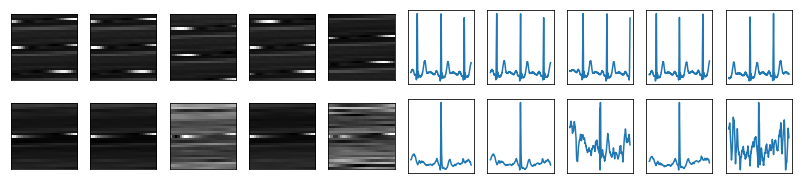

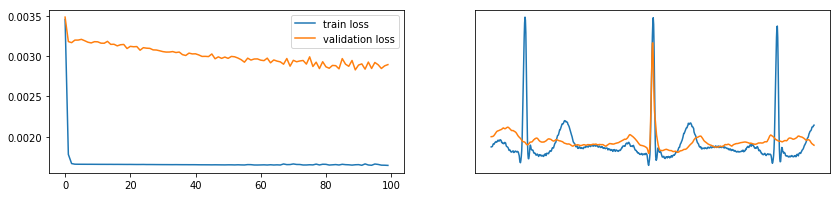

In [787]:
h = fit_encoders(encoders, x_train, x_test, epochs=100, filename='784_64.h5', load_prev=True, verbose=1)

In [85]:
#full_model = create_full_model(encoders[1], layers_dim=[64, 3])
#fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=100, verbose=0)
#plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

(None, 64)
('Evaluating model with fc:', '[3]')
[(None, 784), (None, 64), (None, 3)]


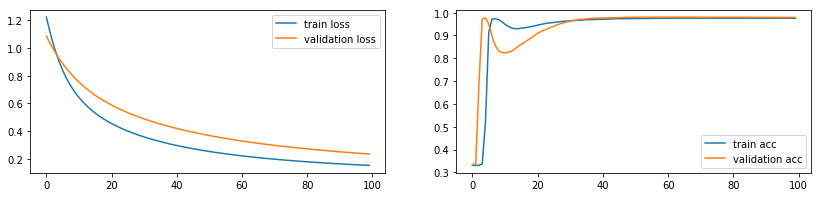

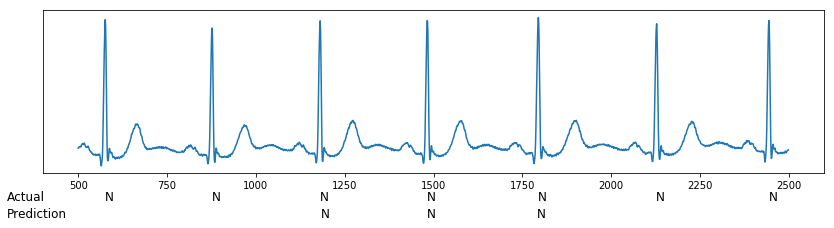

('Evaluating model with fc:', '[10, 3]')
[(None, 784), (None, 64), (None, 10), (None, 3)]


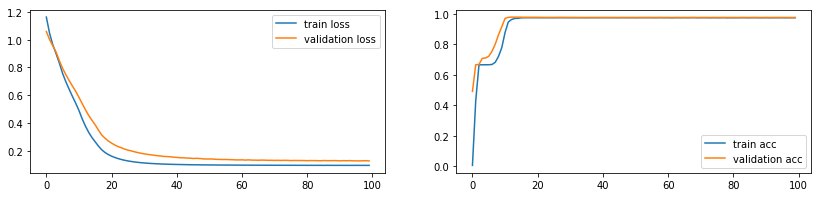

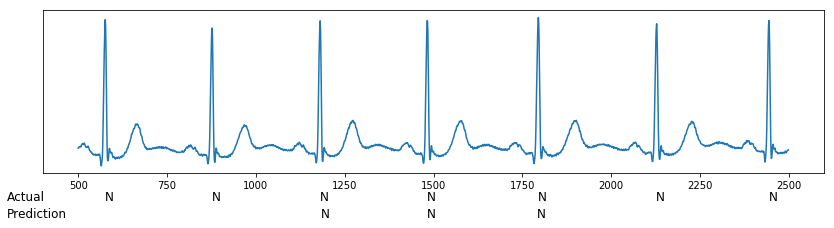

('Evaluating model with fc:', '[32, 3]')
[(None, 784), (None, 64), (None, 32), (None, 3)]


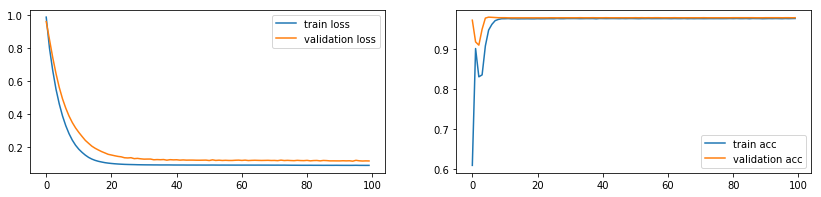

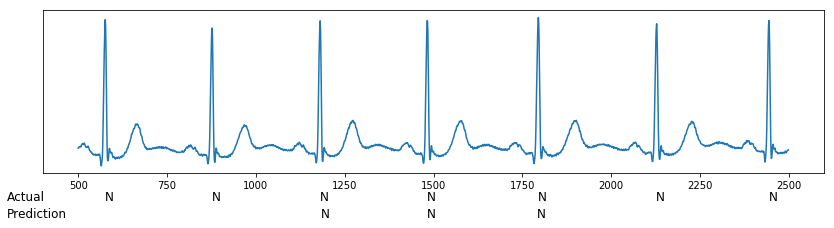

('Evaluating model with fc:', '[64, 3]')
[(None, 784), (None, 64), (None, 64), (None, 3)]


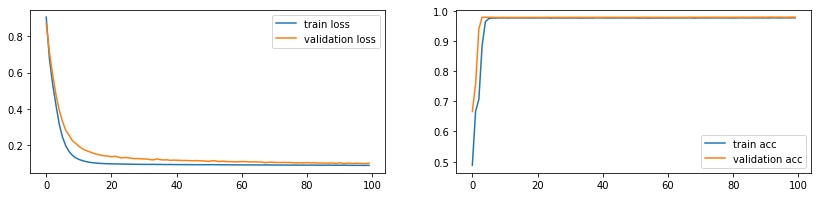

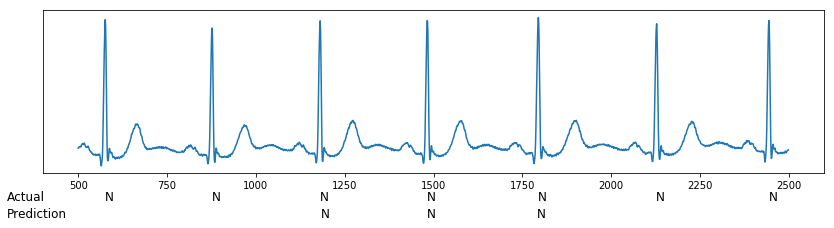

In [788]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

### 784 256 128 64

In [792]:
encoders = create_encoders(784, [256, 128], 64)

Train on 12387 samples, validate on 6246 samples
Epoch 1/200
12387/12387 [==============================] - 4s - loss: 0.0031 - acc: 0.0240 - val_loss: 0.0056 - val_acc: 0.0035
Epoch 2/200
12387/12387 [==============================] - 1s - loss: 0.0018 - acc: 0.0480 - val_loss: 0.0050 - val_acc: 0.0016
Epoch 3/200
12387/12387 [==============================] - 1s - loss: 0.0016 - acc: 0.0471 - val_loss: 0.0046 - val_acc: 0.0088
Epoch 4/200
12387/12387 [==============================] - 1s - loss: 0.0015 - acc: 0.0464 - val_loss: 0.0042 - val_acc: 0.0275
Epoch 5/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0509 - val_loss: 0.0040 - val_acc: 0.0285
Epoch 6/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0591 - val_loss: 0.0039 - val_acc: 0.0275
Epoch 7/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0600 - val_loss: 0.0038 - val_acc: 0.0248
Epoch 8/200
12387/12387 [==============================

12387/12387 [==============================] - 2s - loss: 9.1847e-04 - acc: 0.1016 - val_loss: 0.0027 - val_acc: 0.0384
Epoch 127/200
12387/12387 [==============================] - 2s - loss: 9.0119e-04 - acc: 0.1016 - val_loss: 0.0027 - val_acc: 0.0365
Epoch 128/200
12387/12387 [==============================] - 3s - loss: 9.0051e-04 - acc: 0.1015 - val_loss: 0.0028 - val_acc: 0.0411
Epoch 129/200
12387/12387 [==============================] - 2s - loss: 9.1821e-04 - acc: 0.1014 - val_loss: 0.0027 - val_acc: 0.0363
Epoch 130/200
12387/12387 [==============================] - 2s - loss: 9.1693e-04 - acc: 0.1021 - val_loss: 0.0027 - val_acc: 0.0373
Epoch 131/200
12387/12387 [==============================] - 2s - loss: 9.0726e-04 - acc: 0.1004 - val_loss: 0.0026 - val_acc: 0.0376
Epoch 132/200
12387/12387 [==============================] - 2s - loss: 9.0229e-04 - acc: 0.1006 - val_loss: 0.0027 - val_acc: 0.0354
Epoch 133/200
12387/12387 [==============================] - 2s - loss: 9.09

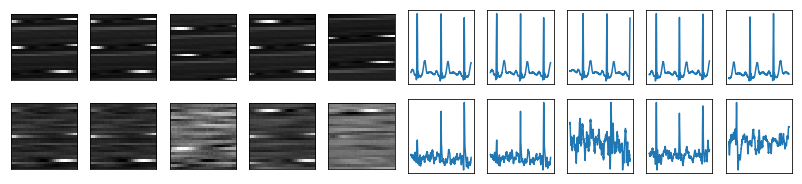

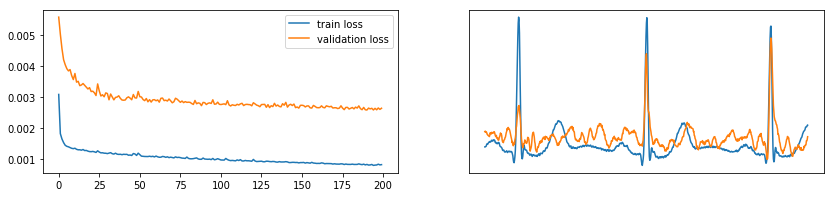

In [796]:
h = fit_encoders(encoders, x_train, x_test, epochs=200, filename='784_256_128_64.h5', load_prev=True, verbose=1)

('Evaluating model with fc:', '[3]')


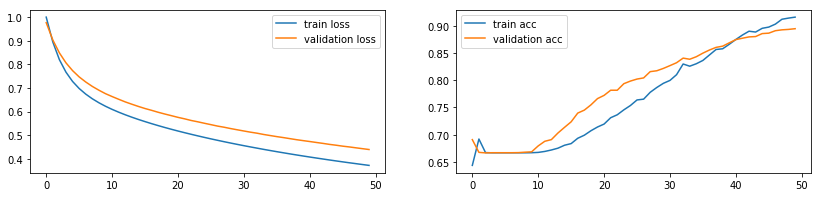

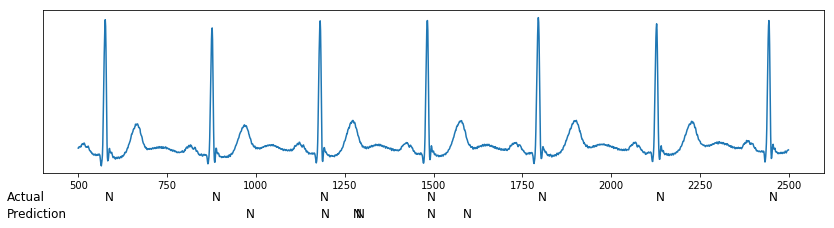

('Evaluating model with fc:', '[10, 3]')


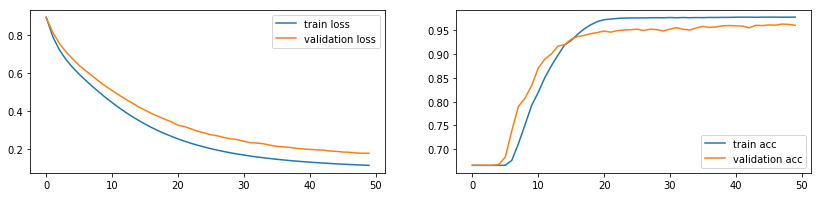

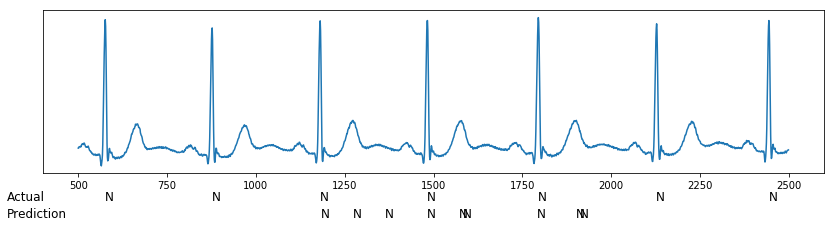

('Evaluating model with fc:', '[32, 3]')


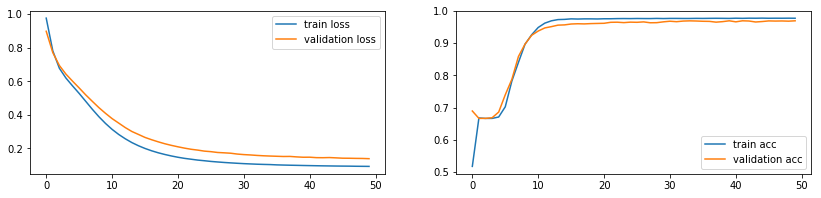

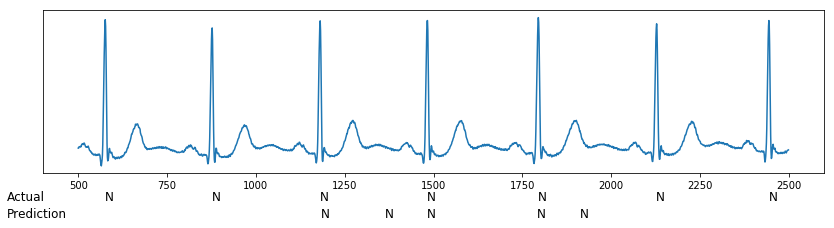

('Evaluating model with fc:', '[64, 3]')


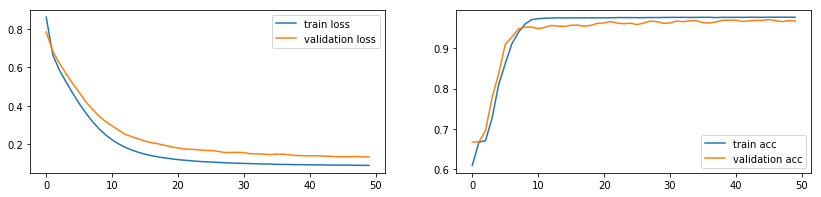

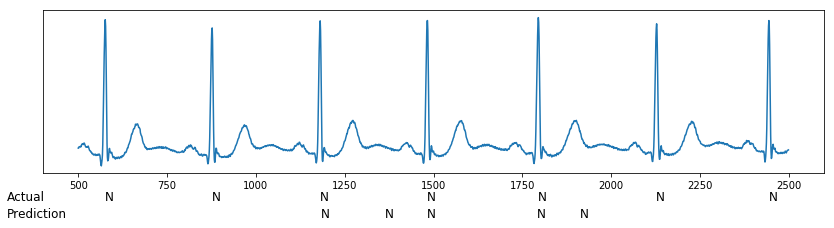

In [797]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=50)

### CONV 16, 8, 8

In [775]:
encoders = create_conv_encoders()

("Can't load weights to model", ValueError('You are trying to load a weight file containing 7 layers into a model with 10 layers.',))
Train on 3303 samples, validate on 826 samples
Epoch 1/2
3303/3303 [==============================] - 7s - loss: 0.0094 - acc: 1.1585e-06 - val_loss: 0.0048 - val_acc: 3.0884e-06
Epoch 2/2
3303/3303 [==============================] - 5s - loss: 0.0041 - acc: 2.3170e-06 - val_loss: 0.0050 - val_acc: 3.0884e-06


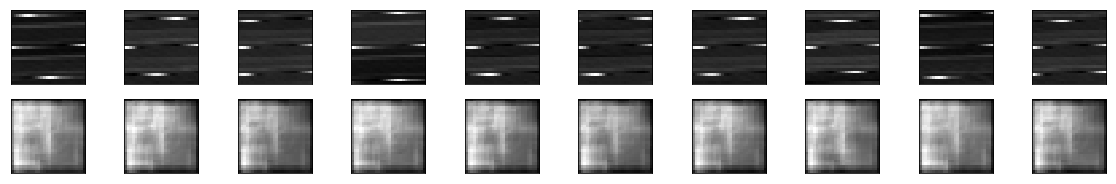

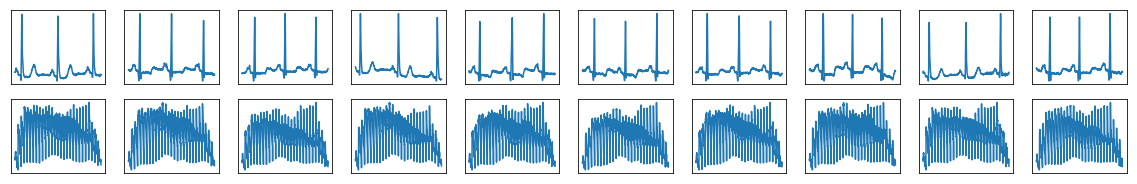

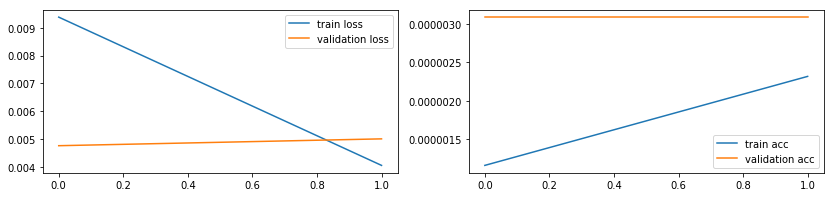

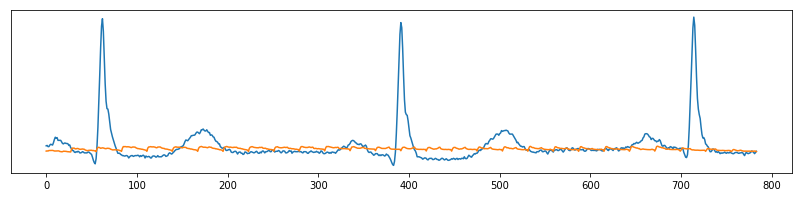

In [776]:
h=fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='conv16_8_8.h5', load_prev=True, verbose=1)

In [780]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

(None, 4, 4, 8)
('Evaluating model with fc:', '[3]')
[(None, 28, 28, 1), (None, 4, 4, 8), (None, 128), (None, 3)]


KeyboardInterrupt: 

### Sequential models

In [28]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024], 'dropout': 0.5},
    {'filters' : [16, 32, 64], 'units': [2048], 'dropout': 0.5},
    {'filters' : [16, 32, 64, 128], 'units': [1024], 'dropout': 0.5}
]
models = evaluate_seq_models(config, epochs = 5, load_prev=True)

Running sequential model with config: {'filters': [16, 32, 64], 'units': [1024], 'dropout': 0.5}
Successfully loaded weights
Train on 70404 samples, validate on 6246 samples
Epoch 1/5


KeyboardInterrupt: 

In [10]:
#0, 1, 8, 11, 15, 16, 19, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35 ,36,37,38,39
# , 40, 41, 42,43, 44,45,46,47
data = load_clean_data(range(48))
validation = load_clean_data([3])

Error while parsing file inxed=2
Error while parsing file inxed=4
Error while parsing file inxed=44


In [11]:
df = data_stats(data)
df.sum().sort_values()

?        0
r        0
B        0
n        0
S        2
e       16
Q       17
J       83
E      106
a      150
j      229
f      260
F      802
A     2543
/     3620
R     6005
V     7069
L     8075
N    79358
dtype: int64

In [51]:
df[['A', 'R', '/', 'V', 'L', 'N']]
#df[['V', 'N']]

A     R     /    V     L     N
0     33     0     0    1     0  2239
1      3     0     0    0     0  1860
2      3     0     0    0     0  1860
3      2     0     0    0     0  2082
4      2     0     0    0     0  2082
5      0     0     0   41     0  2526
6      0     0     0  520     0  1507
7      0     0  2078   59     0     0
8      4     0     0   17     0  1739
9      0     0     0   38  2492     0
10     0     0     0    1  2123     0
11     2     0     0    0     0  2537
12     0     0     0    0     0  1789
13    10     0     0   43     0  1820
14     0     0     0    0     0  1953
15     1     0     0  109     0  2302
16     1     0     0    0     0  1534
17    96  2166     0   16     0     0
18     0     0     0  444     0  1543
19     1     0     0    1     0  1861
20     0     0     0    0     0  2476
21     0     0     0    3     0  1515
22     2  1531     0   47     0     0
23    30     0     0  826     0  1743
24    30     0     0  198     0  1625
25    36     0     0   19     0  2061
26     0     0     0  444     0  2529
27     3     0     0   71     0  2571
28   107    86     0  105  1457     0
29     0     0     0  992     0  1586
30   383     0     0    1     0  2621
31     0     0     0  194     0  2423
32     0  1825     0    0     0   923
33    25     0     0  220     0  2641
34     0     0     0  256  2003     0
35     3     0     0  122     0  2417
36     0     0  1542  162     0   244
37     0     0     0   52     0  1545
38    94     0     0    0     0  1954
39     0     0     0  396     0  2031
40   208     0     0    0     0  2062
41    72     0     0  473     0  2029
42     3     0     0  362     0  1688
43     0     0     0    1     0  2255
44     0     0     0    1     0  2255
45  1382   397     0    0     0     0
46     7     0     0  831     0  2230
47     0     0     0    3     0  2700

In [36]:
for t in ['V', 'N']:
    display(df[t].sort_values(ascending=False).head(10))

29    992
46    831
23    826
6     520
41    473
18    444
26    444
39    396
42    362
34    256
Name: V, dtype: int64

47    2700
33    2641
30    2621
27    2571
11    2537
26    2529
5     2526
20    2476
31    2423
35    2417
Name: N, dtype: int64

In [20]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [8]:
data = load_clean_data(range(37))
validation = load_clean_data(range(37,48))

Error while parsing file inxed=2
Error while parsing file inxed=4
Error while parsing file inxed=44


In [9]:
lb = LabelBinarizer()
x_train, labels = create_features_labels(data, 784, non_beats_per_beat = 2, beat_types = ['V', 'N'])
y_train = lb.fit_transform(labels)

x_test, labels = create_features_labels(validation, 784, non_beats_per_beat = 2,  beat_types = ['V', 'N'])
y_test = lb.transform(labels)

In [53]:
lb.classes_

array(['A', 'N', 'NB'],
      dtype='<U2')

In [10]:
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size = .92)
x_test, _, y_test, _ = train_test_split(x_test, y_test, test_size = .92)

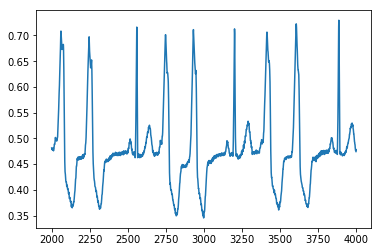

In [101]:
plt.plot(data[0]['signals']['MLII'][2000:4000])

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15235, 784), (15235, 3), (5481, 784), (5481, 3))

In [25]:
from sklearn.model_selection import train_test_split

Running sequential model with config: {'filters': [16, 32, 64], 'units': [1024], 'dropout': 0.5}
Successfully loaded weights
Train on 15235 samples, validate on 5481 samples
Epoch 1/5
15235/15235 [==============================] - 3s - loss: 0.0415 - acc: 0.9887 - val_loss: 0.1876 - val_acc: 0.9619
Epoch 2/5
15235/15235 [==============================] - 3s - loss: 0.0411 - acc: 0.9879 - val_loss: 0.1891 - val_acc: 0.9646
Epoch 3/5
15235/15235 [==============================] - 3s - loss: 0.0349 - acc: 0.9899 - val_loss: 0.2145 - val_acc: 0.9579
Epoch 4/5
15235/15235 [==============================] - 3s - loss: 0.0319 - acc: 0.9916 - val_loss: 0.1632 - val_acc: 0.9666
Epoch 5/5
15235/15235 [==============================] - 3s - loss: 0.0300 - acc: 0.9912 - val_loss: 0.1432 - val_acc: 0.9686


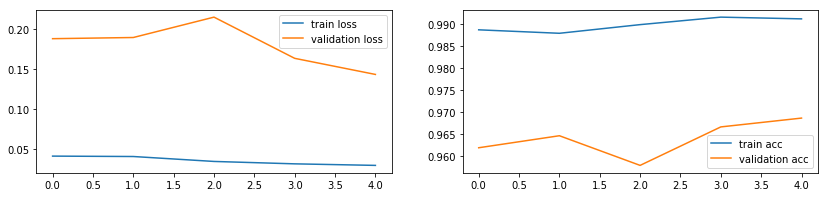

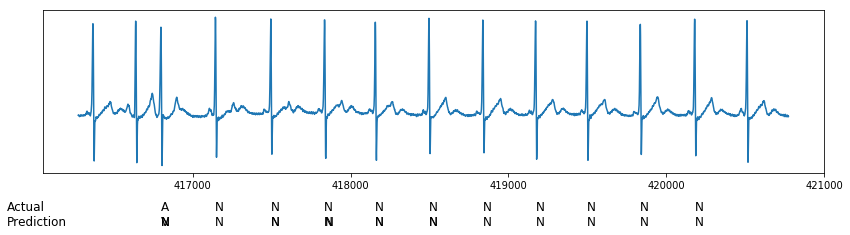

filters   units  dropout   val_acc
0  [16, 32, 64]  [1024]      0.5  0.968619

In [17]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024], 'dropout': 0.5},
#     {'filters' : [16, 32, 64], 'units': [2048], 'dropout': 0.5},
#     {'filters' : [16, 32, 64, 128], 'units': [1024], 'dropout': 0.5}
]
models = evaluate_seq_models(config, epochs = 5, load_prev=True)

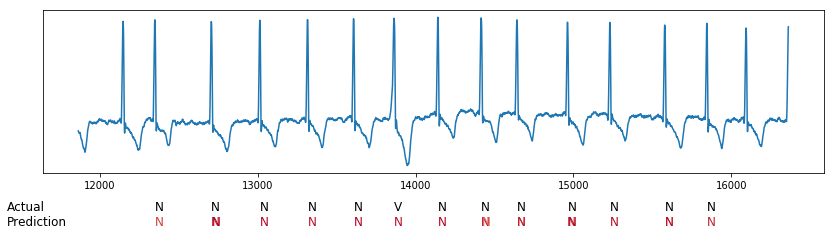

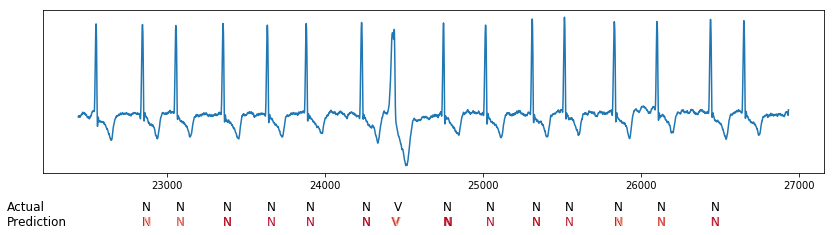

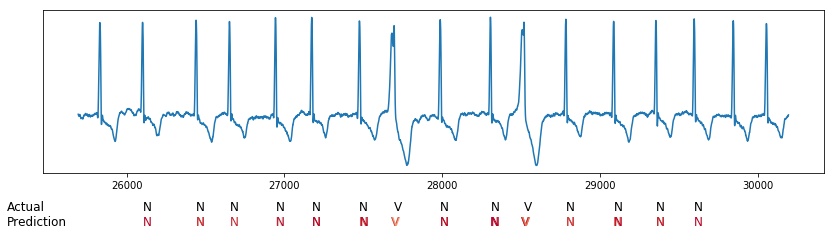

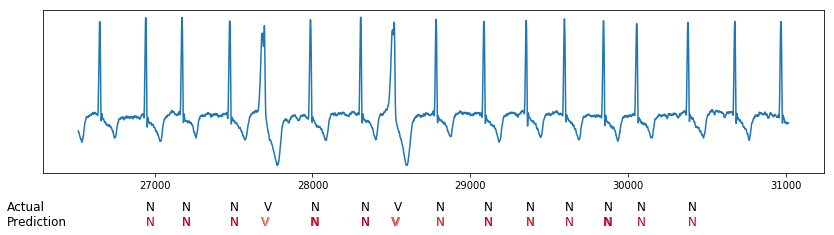

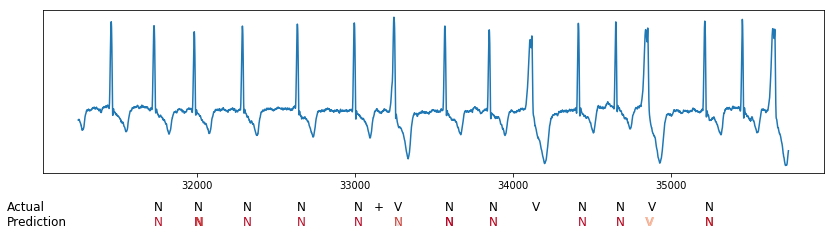

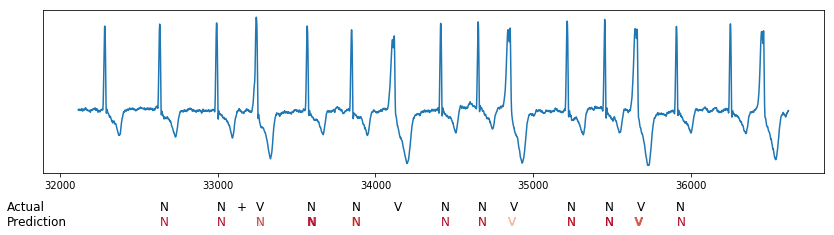

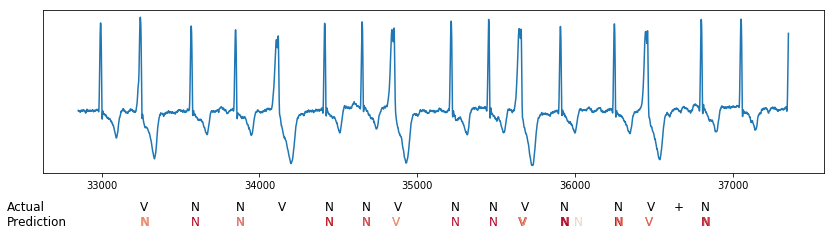

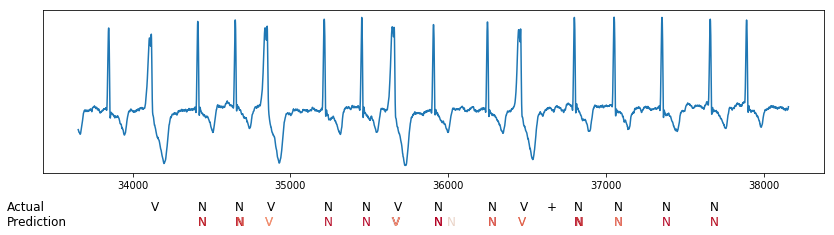

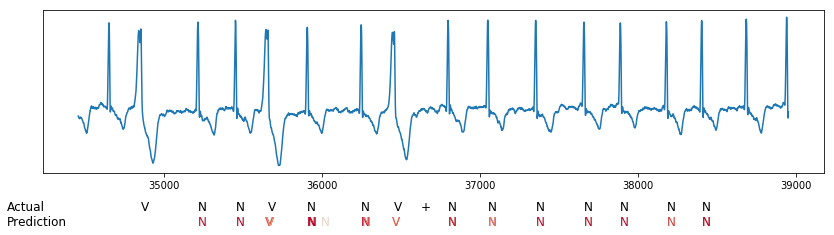

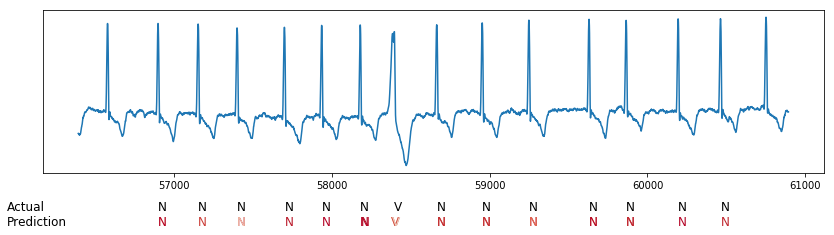

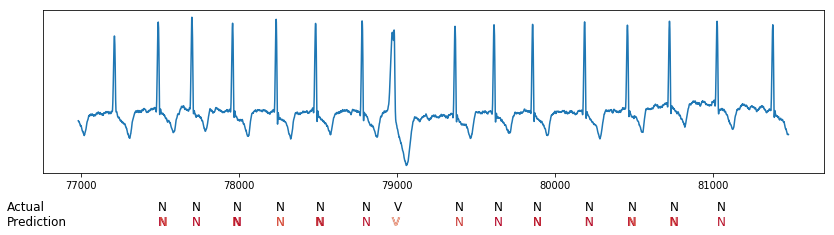

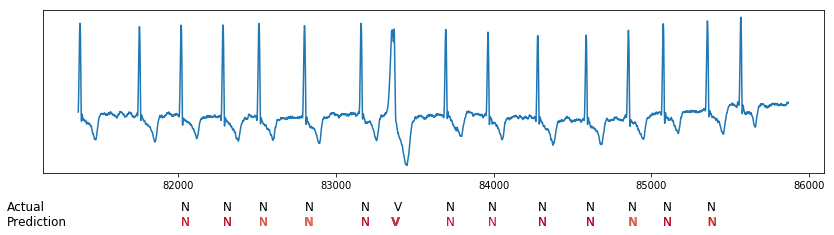

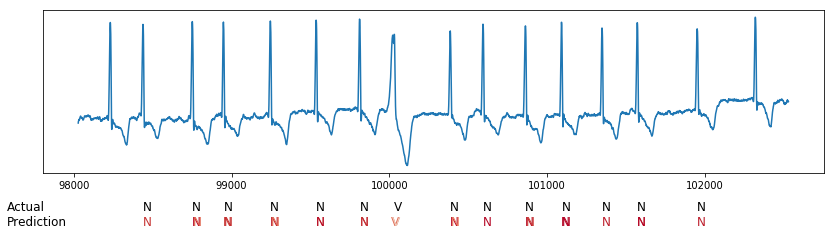

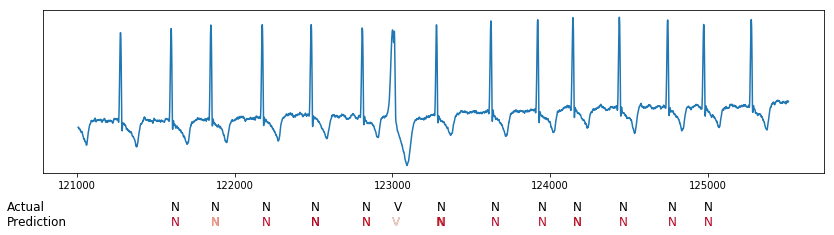

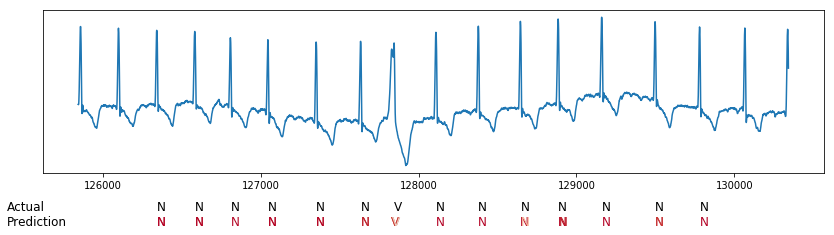

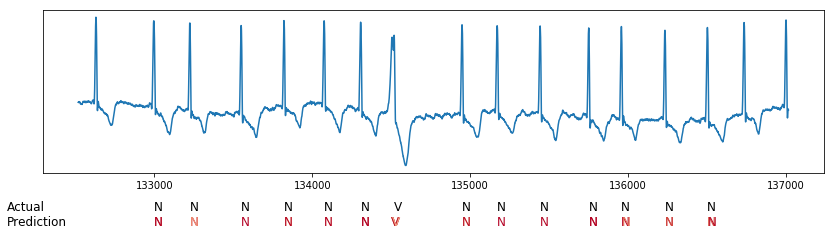

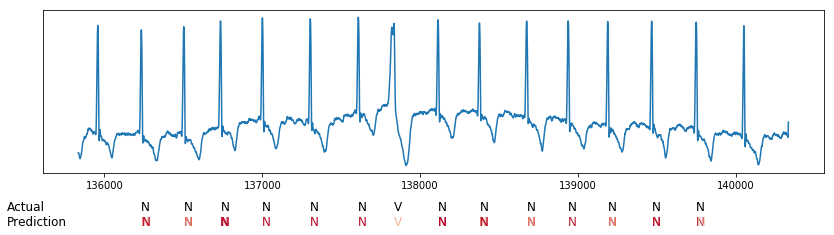

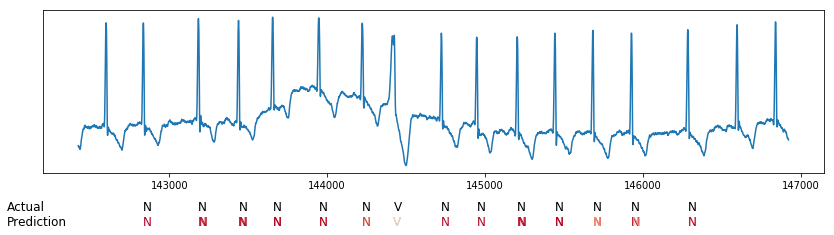

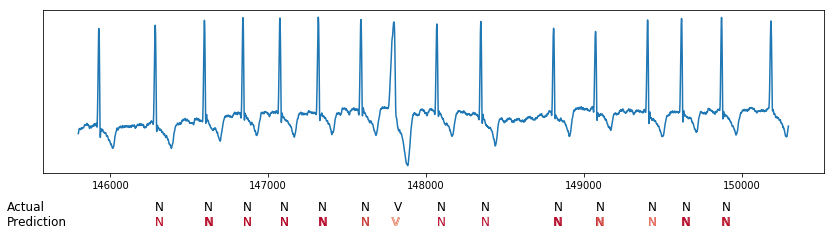

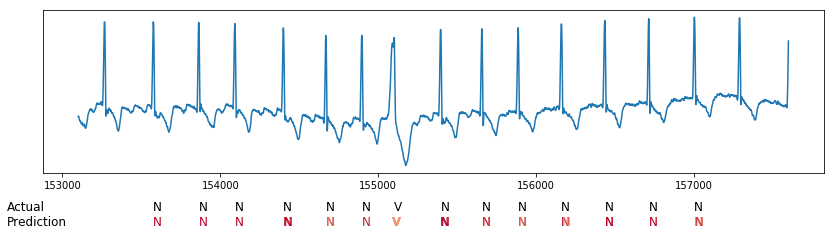

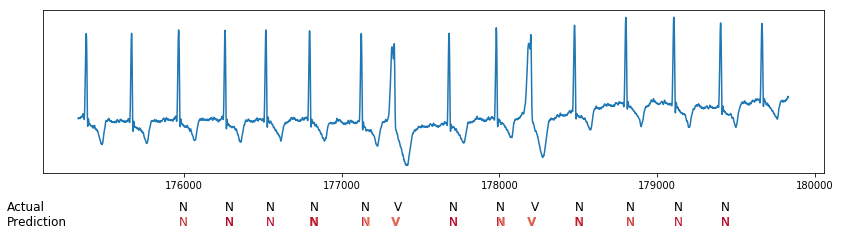

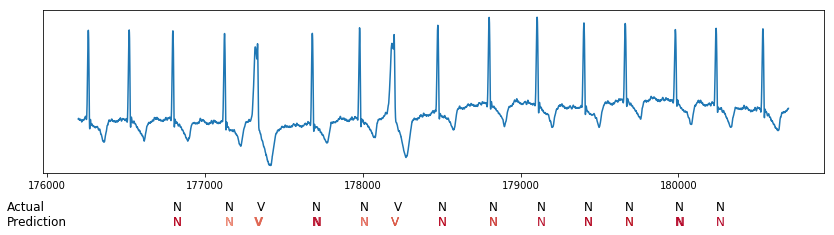

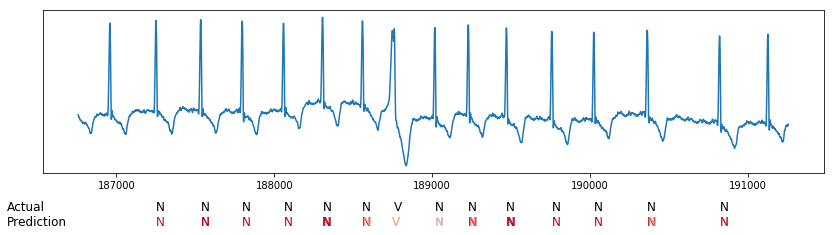

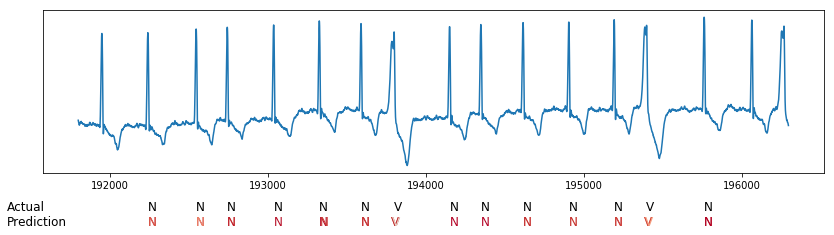

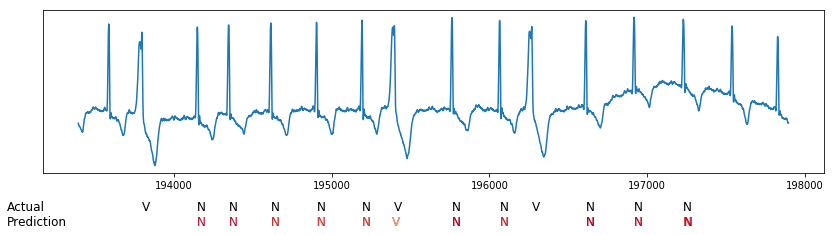

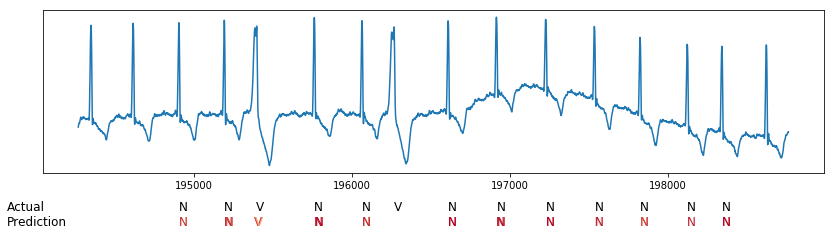

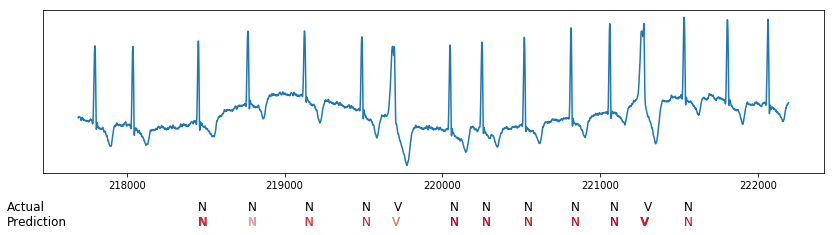

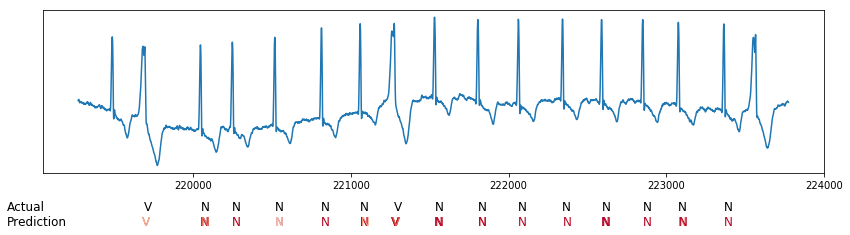

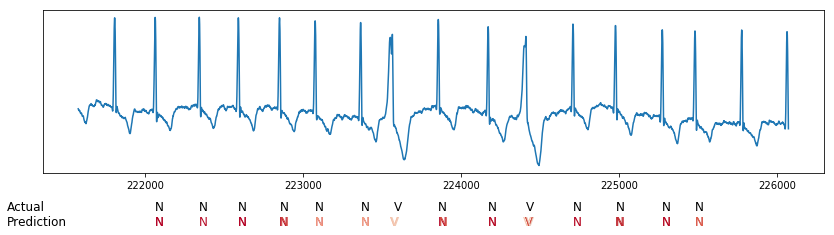

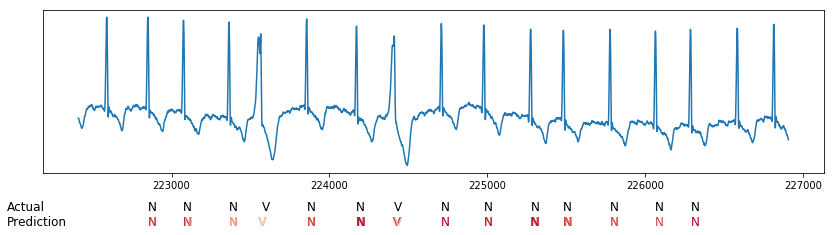

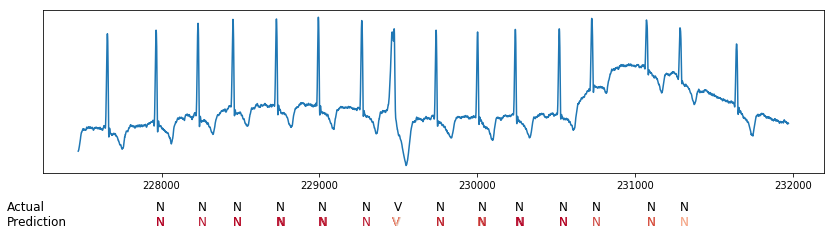

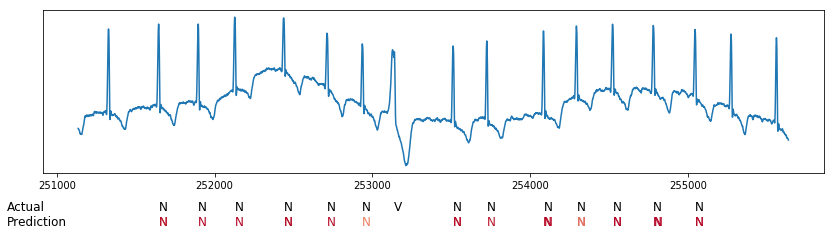

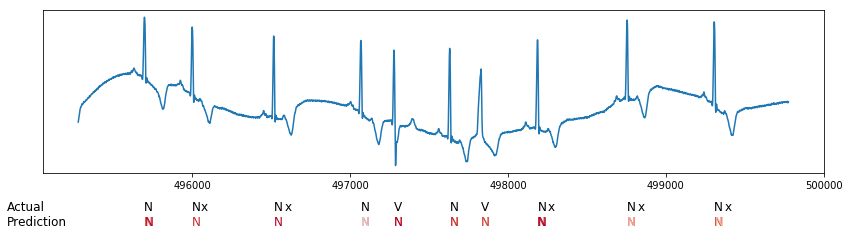

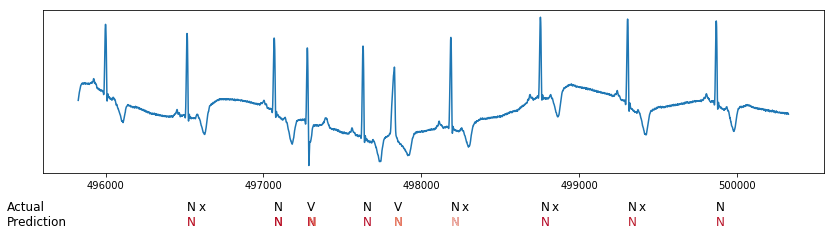

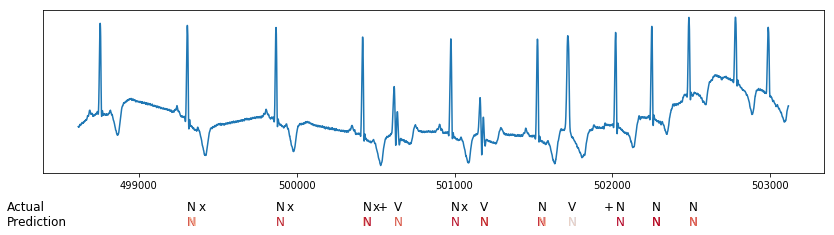

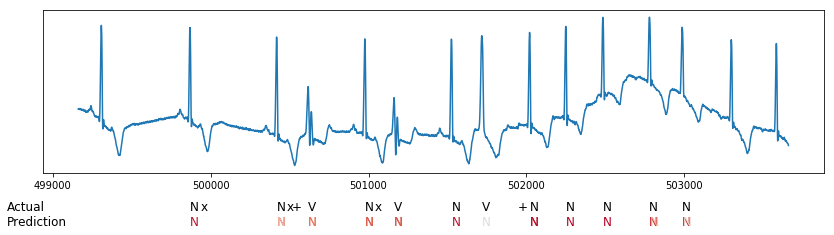

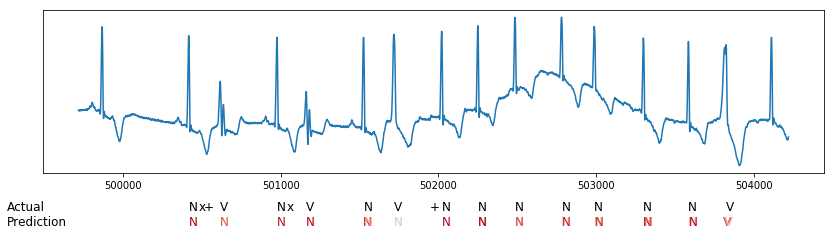

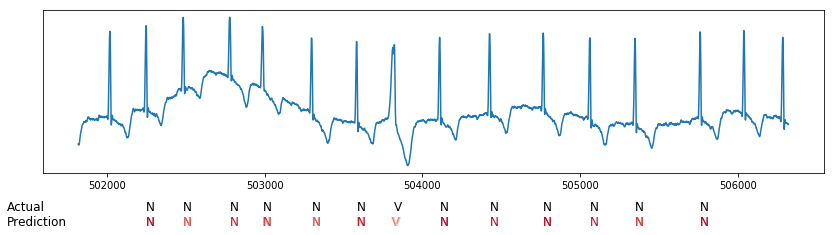

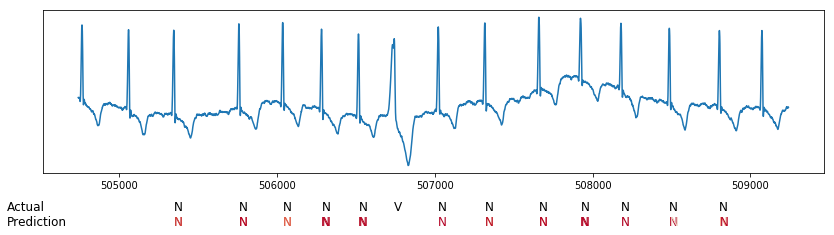

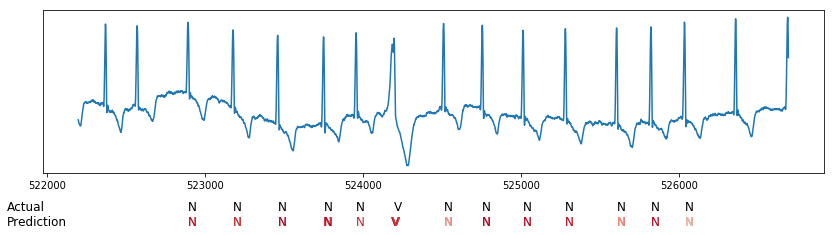

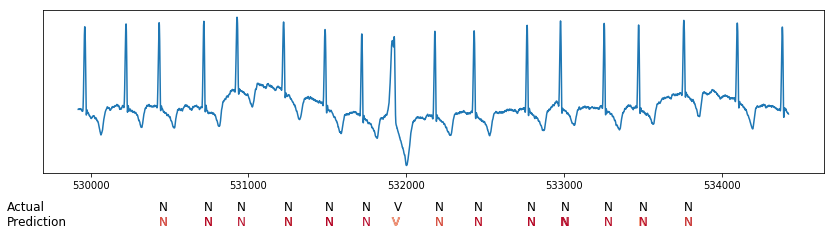

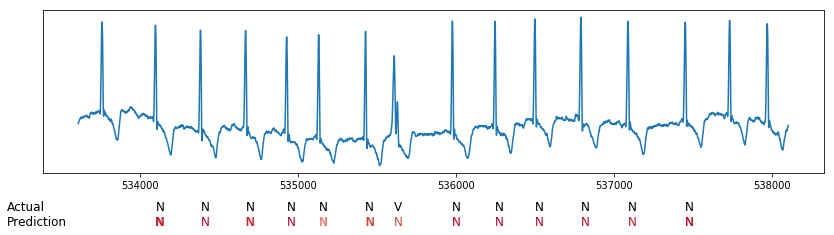

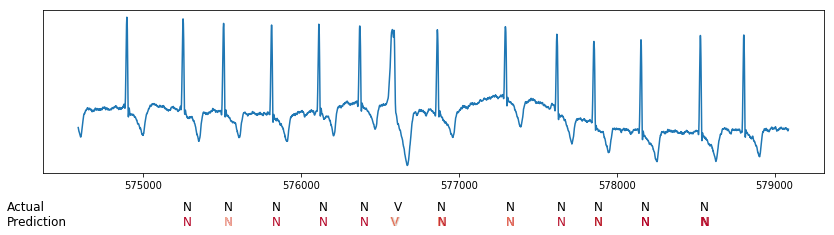

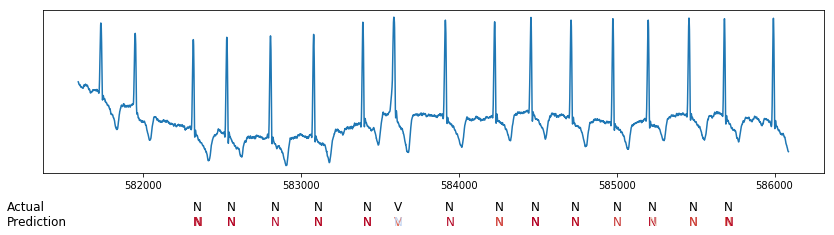

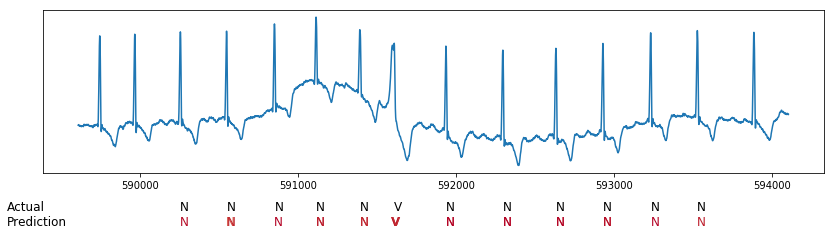

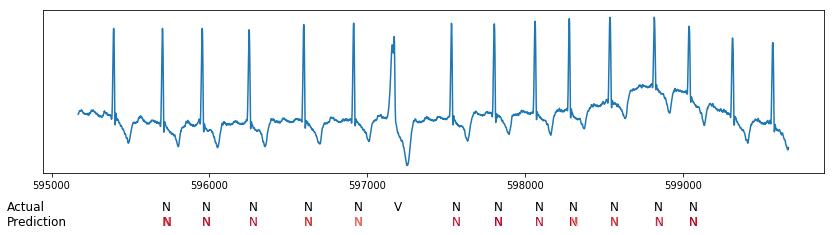

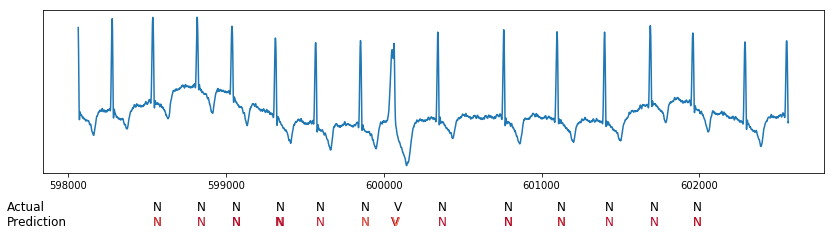

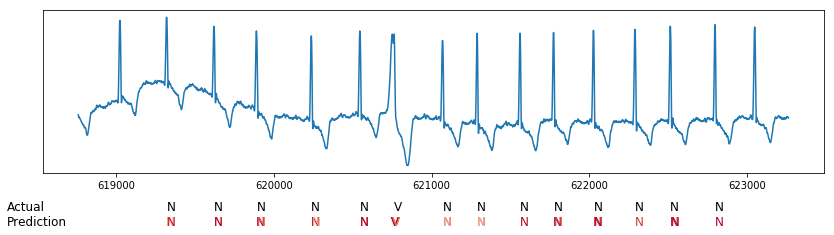

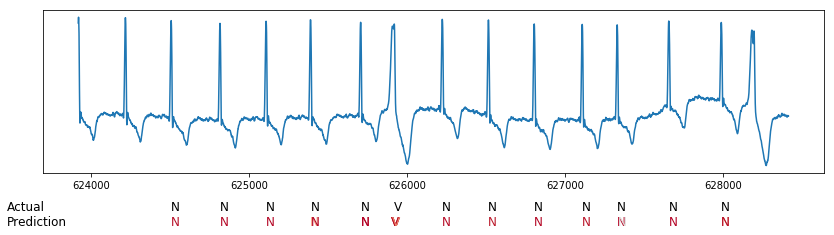

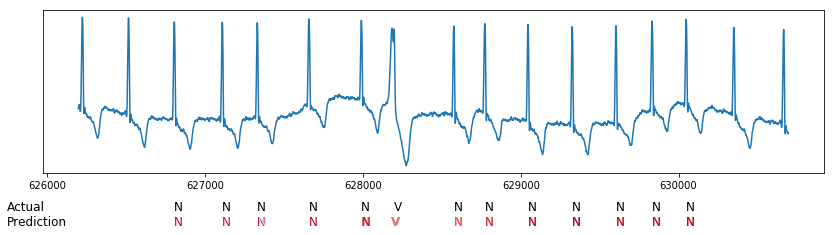

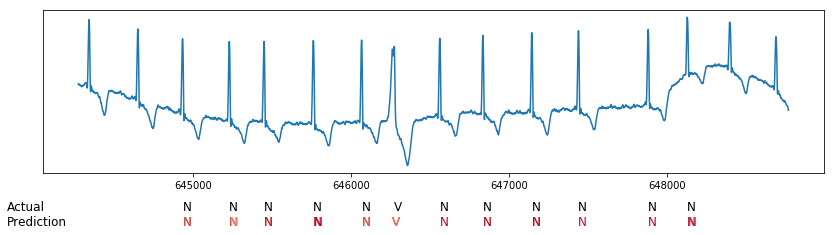

ValueError: cannot reshape array of size 1858 into shape (28,28,1)

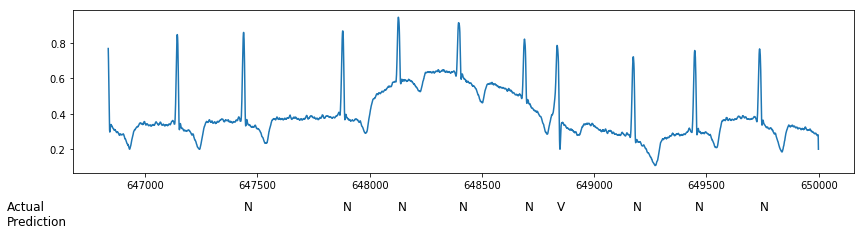

In [22]:
for s in ann['Sample'][ann['Type'] == 'V']:
    plot_validation_diagram(models[0]['model'], lb.classes_, ann, sig,  s - 2000, s + 2500, mark_pred_val=True)      

In [113]:
val2 = load_clean_data([13])
ann = val2[0]['annotations']
sig = val2[0]['signals']

In [21]:
for s in ann['Sample'][ann['Type'] == 'A']:
    plot_validation_diagram(models[0]['model'], lb.classes_, ann, sig,  s - 2000, s + 2500, mark_pred_val=True)      